# Training to align Taps

The idea is to train a kernel to detect beats.  It is assumed that there is typically some sort of percussion on the beat, which the network can pick up on.

In [22]:
%matplotlib notebook
import os.path
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
plt.ion()
from importlib import reload

In [91]:
# load local code
import sys
sys.path.append('src')
import nf_train.data as nfd
reload(nfd)
None

In [92]:
# initialize data source
data_dir = nfd.DataDir('../nf_data/run2/')
print(f"Data contains {len(data_dir.processed)} songs.")
print(f"{len(data_dir.failed)} songs failed to process.")
print(f"One second contains {data_dir.params['rate']} samples.")
print(f"One sample has {data_dir.params['n_filters']} features.")

Data contains 43 songs.
0 songs failed to process.
One second contains 100.0 samples.
One sample has 30 features.


In [93]:
bpms = sorted([(song['info']['bpm'], song['info']['title']) for song in data_dir.processed])
bpms

[(90.0, 'Mirage a Trois'),
 (115.0, "A List of Instructions for When I'm Human"),
 (123.0, 'Canis Lupus'),
 (125.0, 'Another Chance (Original Mix)'),
 (125.0, 'Fuego (Julian Jeweil Remix)'),
 (125.0, 'Going Down (Original Mix)'),
 (125.0, 'Humano (Victor Ruiz Remix)'),
 (125.0, 'Rave (Original Mix)'),
 (125.0, 'Unconditional Beauty (Original Mix)'),
 (126.0, 'Perpendicular (Original Mix)'),
 (126.0, 'Robinson Jr.'),
 (126.0, 'X-Pollination (Original Mix)'),
 (127.0, 'Edging Forward (Original Mix)'),
 (127.0, 'Raita Yksi (Original Mix)'),
 (128.0, 'Acid Trip (Original Mix)'),
 (128.0, 'Homeless (Sebastian Groth Power Edit)'),
 (128.0, 'Iyewaye (Original Mix)'),
 (128.0, 'Knights & Bishops (Original Mix)'),
 (128.0, 'Neuroluminescence'),
 (128.0, 'Target Line featuring Vril (Original Mix)'),
 (128.0, 'Trigger'),
 (129.0, 'Nausea (Trilingo Remix)'),
 (130.0, 'Cydonia (Original Mix)'),
 (130.0, 'Molestrial (Original Mix)'),
 (131.0, 'Fumifugium (Original Mix)'),
 (131.0, 'Hamartia (Origina

In [94]:
data = data_dir.get_file('8116012_Zoombai_Warriors_Surfing_on_a_Small_Chapati_Sound_in_the_East_of_Parvati_Megamix.pickle')
target = np.array(data.beat_grid)[:,None]
hist = np.array(data.hist)
joined_data = np.hstack((hist, target))
#joined_data = np.clip(joined_data, 0, 1)

<IPython.core.display.Javascript object>


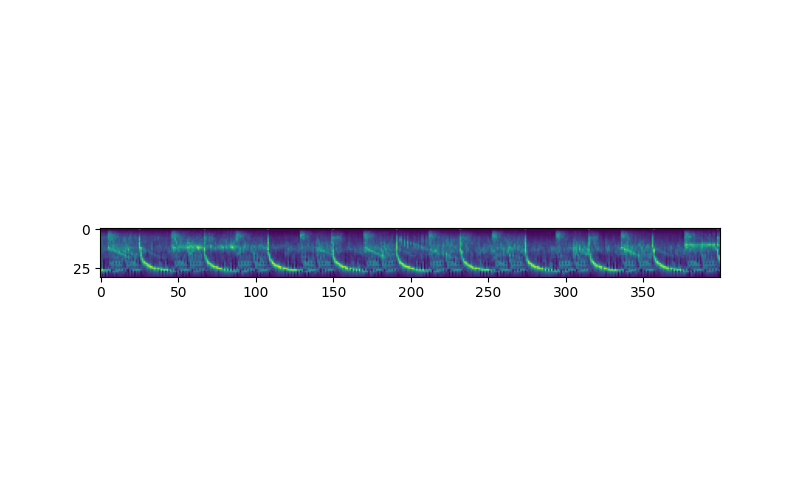

In [71]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
secs = 30 * 5
span = 4
span = span * 100
x = secs * 100
ax.imshow(np.flip(joined_data[x:x+span].T, axis=0), aspect=1)

In [105]:
beats = data.beat_indices
samples = data.get_samples(beats, offset=-10, length=31)
print(len(samples))
samples[0].info

1048


{'title': 'Zoombai Warriors Surfing on a Small Chapati Sound in the East of Parvati (Megamix)',
 'loc': '/home/felix/nextcloud/Music/beatport/8116012_Zoombai_Warriors_Surfing_on_a_Small_Chapati_Sound_in_the_East_of_Parvati_Megamix.mp3',
 'bpm': 145.0,
 'offset': 20575}

<IPython.core.display.Javascript object>


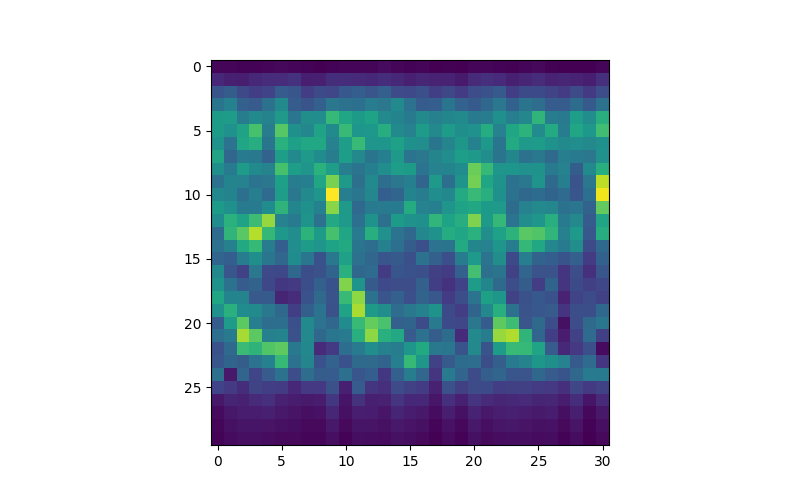

In [129]:
sample = samples[128]
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.imshow(np.flip(np.array(sample.hist).T, axis=0), aspect=1)

## Generate Training Data



In [220]:
def get_pos_neg_indices(min_len_sample: int, target):
    pos_indices = [i for i in range(len(target)) if i > min_len_sample and target[i]]
    neg_indices = [i for i in range(len(target)) if i > min_len_sample and not target[i]]
    return pos_indices, neg_indices

def get_samples(indices, sample_len, hist, target_val):
    result = []
    for i in indices:
        r = {
            'input': np.flip(np.array(hist[i - sample_len - 1 : i - 1], dtype=np.single), axis=0).flatten(),
            'target': np.array(target_val, dtype=np.single)
        }
        result.append(r)
    return result

def samples_from_dataset(data, hist_len: int, n_weight: int):
    target = data['target']
    hist = data['hist']
    p, n = get_pos_neg_indices(hist_len, target)
    random.shuffle(p)
    random.shuffle(n)
    p_samples = get_samples(p, hist_len, hist, 1)
    n_samples = get_samples(n[:len(p) * n_weight], hist_len, hist, 0)
    return p_samples, n_samples

def load_datasets(data_dir: str, hist_len: int, n_weight: int):
    """Takes a directory in which pickle files of songs are located.  Takes the history length
    that should be used for the input to the network.  takes an n_weight, which gives the number
    of negative samples per positive sample."""
    p_samples = []
    n_samples = []
    for track in os.listdir(data_dir):
        print(f"track: {track}")
        path = os.path.join(data_dir, track)
        data = load_data(path)
        ps, ns = samples_from_dataset(data, hist_len, n_weight)
        p_samples.extend(ps)
        n_samples.extend(ns)
    random.shuffle(p_samples)
    random.shuffle(n_samples)
    # split in tr/va
    print(f"p_samples: {len(p_samples)}")
    tr_p_set_size = round(len(p_samples) * 0.7)
    tr_n_set_size = tr_p_set_size * n_weight
    tr_p_samples = p_samples[:tr_p_set_size]
    tr_n_samples = n_samples[:tr_n_set_size]
    tr_samples = tr_p_samples + tr_n_samples
    # validation
    va_p_samples = p_samples[tr_p_set_size:]
    va_n_samples = n_samples[tr_n_set_size:]
    va_samples = va_p_samples + va_n_samples
    return tr_samples, va_samples

## Neural Network

In [222]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [263]:
class SimpleFF(nn.Module):
    def __init__(self,
                 t: int,
                 d: int):
        super(SimpleFF, self).__init__()
        self.t = t
        self.d = d
        self.ff = nn.Linear(t * d, 1)
        
    def forward(self, inputs):
        out = inputs
        out = self.ff(out)
        out = torch.sigmoid(out)
        return out
    
    def save_to_pickle(self, filename):
        data = {}
        data['weights'] = self.ff.weight.detach().numpy().reshape((self.t, self.d)).tolist()
        data['bias'] = self.ff.bias.detach().numpy()[0]
        with open(filename, 'wb') as f:
            pickle.dump(data, f)

In [259]:
def validate_model(model, data_loader):
    model.eval()
    correct = 0
    for sample in data_loader:
        out = model(sample['input'])
        beat = out.data[0] > 0.5
        correct += beat == (sample['target'] == 1)
    v = float(correct)/len(data_loader)
    return v

def train(model, tr_set, va_set, epochs=10):
    optimizer = torch.optim.Adam(model.parameters())
    tr_loader = DataLoader(tr_set, shuffle=True)
    va_loader = DataLoader(va_set, shuffle=True)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        for sample in tr_loader:
            x = sample['input']
            y = sample['target']
            out = model(x)
            #print(f"out: {out}")
            loss = F.mse_loss(out, y[:,None])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        tr_acc = validate_model(model, tr_loader)
        va_acc = validate_model(model, va_loader)
        print(f"Acc tr: {tr_acc:.02f}; va: {va_acc:.02f}")

In [267]:
input_t = 50
tr_samples, va_samples = load_datasets(DATA_DIR, input_t, 5)

track: 3.pickle
track: 0.pickle
track: 4.pickle
track: 6.pickle
track: 5.pickle
track: 2.pickle
track: 1.pickle
p_samples: 7104


In [268]:
model = SimpleFF(input_t, 30)
train(model, tr_samples, va_samples, epochs=3)

Acc tr: 0.95; va: 0.95
Acc tr: 0.95; va: 0.95
Acc tr: 0.96; va: 0.96



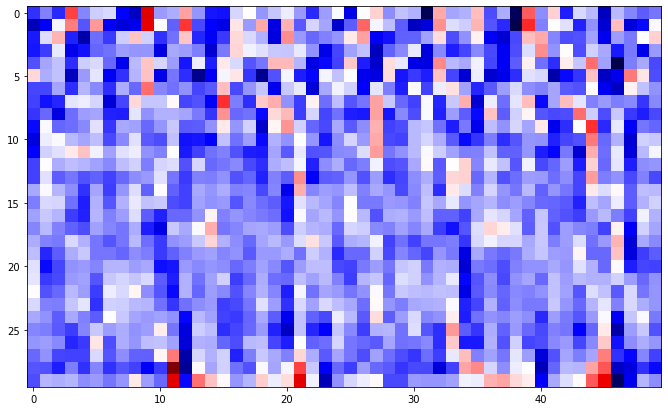

In [269]:
w = model.ff.weight.detach().numpy().reshape((50, 30))
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.imshow(w.T, cmap='seismic')

In [252]:
model.save_to_pickle("model.pickle")

In [249]:
# TODO: normalize values.  Add noise on input.  Try L1 reg. .. batching!
# also I should save the parameters at data generation, carry them through here and 
# save them in the model.pickle to load later